<a href="https://colab.research.google.com/github/karencfisher/COVID19/blob/main/notebooks/Unet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/COVID-19_Radiography_Dataset'
!unzip -q /content/drive/MyDrive/COVID-19_Radiography_Dataset/segment_data.zip

!wget https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py

Mounted at /content/drive
--2021-09-02 01:37:13--  https://raw.githubusercontent.com/karencfisher/COVID19/main/tools/util.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5910 (5.8K) [text/plain]
Saving to: ‘util.py’

util.py             100%[===================>]   5.77K  --.-KB/s    in 0s      

2021-09-02 01:37:13 (66.5 MB/s) - ‘util.py’ saved [5910/5910]



In [68]:
import os
import random

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
import pandas as pd

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, BatchNormalization, Input
from tensorflow.keras.layers import Conv2DTranspose, Concatenate, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.applications.densenet import preprocess_input

import util

### Define blocks

In [3]:
def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding='same')(input)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  x = Conv2D(num_filters, 3, padding='same')(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)

  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

### Build U-Net model function

In [4]:
def build_unet(input_shape, num_layers, min_num_filters=64):
  inputs = Input(input_shape)
  skip_features = []

  s, x = encoder_block(inputs, min_num_filters)
  skip_features.append(s)

  for i in range(1, num_layers):
    num_filters = min_num_filters * 2 ** i
    s, x = encoder_block(x, num_filters)
    skip_features.append(s)

  num_filters = min_num_filters * 2 ** num_layers
  x = conv_block(x, num_filters)

  for i in range(num_layers):
    num_filters /= 2
    s = skip_features.pop()
    x = decoder_block(x, s, num_filters)

  x = Conv2D(1, 1, padding='same')(x)
  outputs = Activation('sigmoid')(x)

  model = Model(inputs, outputs, name='U-Net')
  return model
   

### Visualize training data

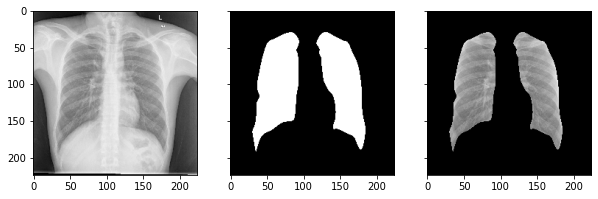

In [37]:
images_path = os.path.join('segment_data', 'images')
masks_path = os.path.join('segment_data', 'masks')

images_list = os.listdir(images_path)
images_list.sort()
masks_list = os.listdir(masks_path)
masks_list.sort() 

index = random.randint(0, len(images_list))
image_path = os.path.join(images_path, images_list[index])
mask_path = os.path.join(masks_path, masks_list[index])
image = load_img(image_path)
image = img_to_array(image)
mask = load_img(mask_path, color_mode='grayscale')
mask = img_to_array(mask)

f, axes = plt.subplots(1, 3, sharey=True, figsize=(10, 10))
axes[0].imshow(image/255.)
axes[1].imshow(np.squeeze(mask)/255., cmap='gray')
axes[2].imshow((image/255.) * (mask/255), cmap='gray')

### Build X and y from image files

In [69]:
n_samples = len(images_list)
X = np.zeros((n_samples, 224, 224, 3))
y = np.zeros((n_samples, 224, 224, 1))
for i, fn in enumerate(images_list):
  image_path = os.path.join(images_path, fn)
  image = load_img(image_path)
  image = img_to_array(image)
  image = preprocess_input(image)
  X[i] = image

  mask_path = os.path.join(masks_path, masks_list[i])
  mask = load_img(mask_path, color_mode='grayscale')
  mask = img_to_array(mask) / 255.
  y[i] = mask

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [56]:
input_shape = (224, 224, 3)
model = build_unet(input_shape, 4)
model.summary()

Model: "U-Net"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 224, 224, 64) 256         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 224, 224, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________